# TP bioinfo - Bioinformatics Learning Lab 2023 

# **Introduction**

---


Le projet BILL est un projet d'innovation pédagogique dans lequel les étudiants deviennent acteurs de leur formation en utilisant leur acquis pour répondre à de vraies questions scientifiques dans un environement pluridisciplinaire. Nous allons donc ensemble poser des hypothèses de travail et tenter d'y répondre en groupe. 

Cette année encore, vous allez pouvoir étudier l'évolution de l'herpesvirus de la carpe (CyHV-3 ou KHV), projet de recherche porté Jean-Christophe Avarre, chercheur IRD-ISEM.

Vos encadrants bioinformaticiens sont :

*   Anthony Bourreux
*   Catherine Breton
*   Emira Cherif
*   Anna-Sophie Fiston-Lavier
*   Arnaud Soulier

Si vous avez des questions concernant l'UE, merci de voir avec Anna-Sophie Fiston-Lavier (anna-sophie.fiston-lavier@umontpellier.fr), co-porteuse du projet BILL et la responsable du module HAU802I - BILL. 

# **Projet de Recherche**

---


Le KHV (*CyHV-3*) est un virus de carpe commune (*Cyprinus carpio*). De précédentes études ont suggérées une évolution rapide du génome du virus associée à des taux variables de morbidité et mortalité ([Klafack et al 2019](https://www.mdpi.com/1999-4915/11/8/754)). 

Dans le cadre du projet BILL, on souhaite poursuivre la compréhension de l’évolution de ce virus *in vitro*.

## **Hypothèse** 

L'émergence de souches virulentes de *CyHV-3* serait associée à une fragmentation des gènes (perte de fonction).

## ** Quelles questions pouvons-nous poser et comment y répondre ? 

1. **Comparer les générations P1, P10, P20 avec P30, P40 et P50 avant et après le stress thermique (15°C ou 28°C). Voir les effets du stress thermique sur le génome du CyHV-3 (avant et après le stress).**
2. **Comparer les effets du stress thermique (15°C et 28°C) sur les générations P30, P40 et P50. Voir les effets du stress thermique sur le génome du CyHV-3 (pendant le stress).**
3. **Comparer les générations P10 et P20 pour quantifier l'effet de la dérive génétique (quantifier les fréquences alléliques du virus CyHV-3 au fil des passages P10 et P20).**



## **Séquençage  de lectures longues (MK1C@Nanopore)**

Paramètres des MK1C :

demander aux étudiants ? S'ils ne savant pas, il devrons y répondre  durant le TP.

* **ADN**
* **PCR-free (pas de PCR)**
* **Barcode: Oui/Oxford Nanopore - Rapid Barcoding Sequencing (SQK-RBK004)**
* **taille min des reads qui peuvent passer les nanopore: supérieure à 1kb (200 bp par défaut)**
* **Score phred : 8**
* **Enriched deplet : Non**
* **48h max de séquençage**
* **type de basecalling: oui/fast**
* **avec mapping**




## ** Quelles sont les analyses possibles ? 
* **Vérification de la qualité et de la quantité des reads.**
* **Analyse du coverage (couverture) et du depth (profondeur) des reads.**
* **Alignement des reads avec le génome de référence du CyHV-3 (souche italienne) pour vérifier que le séquençage c'est bien déroulé.**
* **Analyse des variants des reads (voir les différentes mutations apparues dans le génome du virus au fil des générations).**


# **Explications de la pipeline du Snakemake du projet BILL**
---
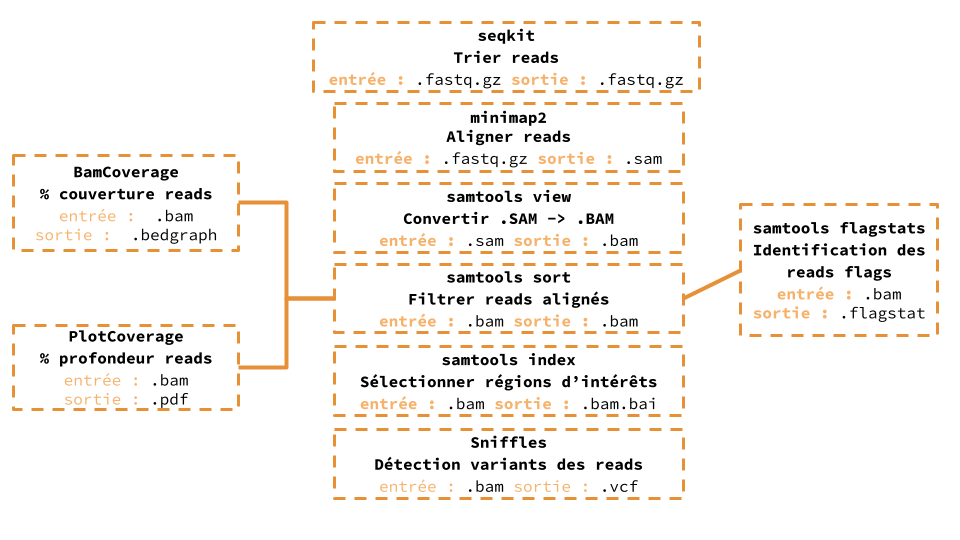

**Figure 1 - Pipeline du Snakemake du projet BILL - [Noëlie Palermo. 2023].**

La pipeline représente les neuf logiciels lancés par le **Snakemake** **[1]** (ver. 6.14.0), qui a été programmé avec Python3.7. Les fichiers d'entrés et de sorties des programmes, ainsi que leur extension.

In [ ]:
snakemake -s SCRIPTS/Snakefile --cores 1 --keep-going --cluster-config SCRIPTS/cluster_config.yaml --cluster "sbatch -J {cluster.job-name} -A recombinationlandscape -p {cluster.queue} {cluster.nodes} {cluster.cpus} {cluster.log} {cluster.mem}" --jobs 5

* *-s*, utilise le fichier *Snakefile* pour lancer la suite des logiciels de la pipeline.
* *--cores*, donne le nombre de coeurs utilisés par le programme.
* *--keep-going*, permet au Snakemake de continuer son excéution même si certaines tâches échouent. 
* *--cluster-config*, spécifie le fichier de configuration *.yaml* pour fonctionner dans le cluster NGSTC. 
* *--cluster*, précise les paramètres du cluster pour exécuter les logiciels.
* *--jobs*, donne le nombre maximal de programmes à excécuter en parrallèle.

**Seqkit** **[2]** (ver. 2.1.0), est utilisé pour traiter les séquences FASTA et FASTQ.

In [ ]:
seqkit seq -m {trim} {input.raw} -o {output.trimed} 2> {log.out}

* *seq*, analyse les séquences ADN ou ARN.
* *-m*, permet de sélectionner les reads plus grand qu'un seuil défini. Pour le séquençage du projet BILL, la taille des reads devaient mesurer minimum **1000 bp** (paires de bases). 
* *-o* permet de spécifier le fichier de sortie du logiciel.


**Minimap2** **[3]** (ver. 2.17), aligne les séquences ADN ou ARNm (reads issus de PacBio ou d’Oxford Nanopore) avec un génome de référence. Le fichier de sortie du programme est au format **Sequence Alignment Map** (*.sam*).

In [ ]:
minimap2 --MD -ax map-ont -t {threads} {input.ref} {input.read} -o {output.sam} 2> {log.out}

* *-MD*, génère les séquences de références de KHV-J dans l'alignement.
* *-a*, génère le **CIGAR** (Compact Idiosyncratic Gapped Alignment Report). 
* *-x map-ont*, aligne les *long* reads, de 10% d'erreur, au génome de référence. 
* *-t*, ajuste le nombre de *threads* ou tâches à exécuter en parallèle pour le logiciel, au nombre de 4.

**Samtools view** **[4]** (ver. 1.9), convertit le fichier *sam* donné par l’alignement de minimap2 en fichier binaire **Binary Alignement Map** (*.bam*). 

In [ ]:
samtools view -uhbS -@ {threads} -F 4 {input.sam} -o {output.mapped} 2> {log.out}

* *-u*, garde le fichier d'entrée au format BAM.
* *-b*, donne un fichier de sortie BAM. 
* *-h*, permet d'inclure les entêtes dans le fichier de sortie. 
* *-S*, est une option qui était nécessaire pour analyser les fichiers au format SAM. Elle est maintenant ignoré edans les version récentes de Samtools. * *-@*, ajoute 2 *threads* à la compression du fichier BAM .
* *-F*, ne donne pas des FLAGS en bytes pour les reads alignés.

**Samtools sort** **[5]** (ver. 1.9), filtre les alignements des reads selon leur tag, leur position ou leur nom.

In [ ]:
samtools sort -l 0 -@ {threads} {input.mapped} -o {output.sorted} 2> {log.out}

 * *-l 0* donne un fichier décompressé au format BAM.

**Samtools flagstat** **[6]** (ver. 1.9), identifie les différents flags (https://samtools.github.io/hts-specs/SAMv1.pdf) des reads. Il donne des informations sur la réussite du séquençage de ces derniers en fonction des statistiques des flags. Le fichier est au format *flagstat*.

In [ ]:
samtools flagstat -@ {threads} {input.sorted} > {output.stats} 2> {log.out}

* *-@*, autorise 2 *threads* en plus lorsque le fichier BAM est analysé.

**Samtools index** **[7]** (ver. 1.9), utilise les résultats de samtools view pour indexer seulement les régions d’intérêts. Le fichier obtenu est indexé au format BAM.BAI.

In [ ]:
samtools index -@ {threads} {input.sorted} 2> {log.out}

**BamCoverage** **[8]** (ver. 3.5.0), mesure le pourcentage de *cover* ou couverture des reads sur le génome de référence KHV-J. 

In [ ]:
bamCoverage -p {threads} -b {input.sorted} -of "bedgraph" --effectiveGenomeSize {genomeSize} --normalizeUsing RPGC -o {output.bedgraph} 2> {log.out}

* *-p*  ou *--numberOfProcessors*, détermine le nombre de processeurs que doit utiliser bamCoverage. Pour ce Snakemake le nombre de processeurs utilisés est de 4.
* *-b* ou *--bam*, vérifie que le fichier d'entré est bien au format BAM.
* *-of*, permet d'obtenir un fichier au format *bedgraph*.
* *--effectiveGenomeSize*, donne la taille du génome qui peut être mappé, il est ici de **295052 pb**.
* *--normalizeUsing RPGC*, normalise le nombre de reads par *bin* (fenêtre de taille constante qui permet de compter les reads) pour une couverture moyenne de 1x.

**PlotCoverage** **[8]** (ver. 3.5.0), détermine le pourcentage de *depth* ou profondeur, des reads qui recouvre la région génomique du *Cyprinid herpesvirus 3*. Les deux graphiques générés permettent de représenter la fréquence de couverture des reads et la partie du génome qui à une profondeur de séquençage de 2 à 10 reads par paire de bases.

In [ ]:
plotCoverage -p {threads} -b {input.sorted} --smartLabels --plotFileFormat pdf -o {output.pdf} 2> {log.out}

Le nombre de proccesseur utilisé par plotCovearge est de 8. 
* *-b* ou *--bam*, vérifie que la liste des fichiers BAM indexés soient séparés par des espaces.
* *--smartLabels*, utilise le nom du fichier (sans son chemin et son extension) pour nommer des variables.
* *--plotFileFormat pdf*, permet d'obtenir un fichier de sortie au format **Portable Document Format** (*.pdf*).

**Sniffles** **[9]** (ver. 1.0.11), détecte les variants ou mutations des *long* reads issus du séquençage d’Oxford Nanopore. Ces variations peuvent être des substitutions, des délétions, des insertions et des duplications **[10]**. Les mutations mises en valeur par les reads peuvent montrer un impact de ces dernières sur les étapes de transcription de l’ARN et de traduction des protéines **[10]**.

In [ ]:
sniffles -t {threads} -i {input.sorted} --minsvlen 30 --minsupport 10 -v {output.vcf} 2> {log.out}

* *-t*, spécifie le nombre de *threads* à utiliser pour augmenter la vitesse des processeurs, elle est par défaut à 4.
* *-i* ou *--input*, récupère le fichier des reads alignés et indexés au format BAM.BAI.
* *--minsvlen*, précise la taille minimum des **SV** (Structural Variant) à **30 pb**.
* *--minsupport*, cible le nombre minimum de supports de reads pour un SV qui est de **10**.
* *-v*, donne un fichier **Variant Call Format** (*.vcf*).

# **Références**
---
**[1]** Mölder F, Jablonski KP, Letcher B, Hall MB, Tomkins-Tinch CH, Sochat V, Forster J, Lee S, Twardziok SO, Kanitz A, Wilm A, Holtgrewe M, Rahmann S, Nahnsen S, Köster J. Sustainable data analysis with Snakemake. F1000Res. 2021 Apr 19;10:33. doi: 10.12688/f1000research.29032.2. PMCID: PMC8114187.

**[2]** W Shen, S Le, Y Li*, F Hu*. SeqKit: a cross-platform and ultrafast toolkit for FASTA/Q file manipulation. PLOS ONE. doi:10.1371/journal.pone.0163962.

**[3]** Li, H. (2018). Minimap2: pairwise alignment for nucleotide sequences. Bioinformatics, 34:3094-3100. doi:10.1093/bioinformatics/bty191

**[4]** Li, H. Samtools. 2023. samtools view – views and converts SAM/BAM/CRAM files. Disponible sur : http://www.htslib.org/doc/samtools-view.html (Consulté le 03 mars 2023)

**[5]** Li, H. Samtools. 2023. samtools sort – sorts SAM/BAM/CRAM files. Disponible sur : http://www.htslib.org/doc/samtools-sort.html (Consulté le 03 mars 2023)

**[6]** Li, H. Samtools. 2023. samtools flagstat – counts the number of alignments for each FLAG type; Disponible sur : http://www.htslib.org/doc/samtools-flagstat.html (Consulté le 03 mars 2023)

**[7]** Li, H. Samtools. 2023. samtools index – indexes SAM/BAM/CRAM files; Disponible sur : http://www.htslib.org/doc/samtools-index.html (Consulté le 03 mars 2023)

**[8]** Ramírez, Fidel, Devon P. Ryan, Björn Grüning, Vivek Bhardwaj, Fabian Kilpert, Andreas S. Richter, Steffen Heyne, Friederike Dündar, and Thomas Manke. deepTools2: A next Generation Web Server for Deep-Sequencing Data Analysis. Nucleic Acids Research (2016). doi:10.1093/nar/gkw257.

**[9]** Sedlazeck, F.J., Rescheneder, P., Smolka, M. et al. Accurate detection of complex structural variations using single-molecule sequencing. Nat Methods 15, 461–468 (2018). https://doi.org/10.1038/s41592-018-0001-7

**[10]** HGVS. Sequence Variant Nomenclature. 2020. HGVS simple. Disponible sur : https://varnomen.hgvs.org/bg-material/simple/#:~:text=Variants%20are%20usually%20detected%20by,rarely%20the%20consequence%20on%20RNA (Consulté le 3 mars 2023).

# **Explications du logiciel BCFtools**
---
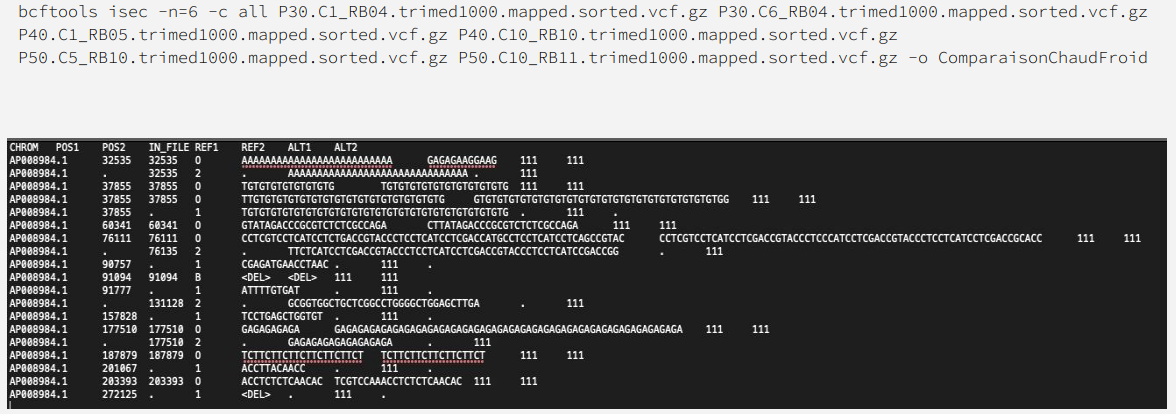

**Figure 2 - La commande du logiciel BCFtools pour analyser les fichiers VCF de Sniffles - [Ambre Petit. M1 Bioinformatique - Université de Montpellier. 2023].**

Le logiciel **BCFtools** **[10]** permet d'analyser les variants des reads au format **Variant Call Format (VCFs)** et **Binary Call Format (BCFs)**. 
* *isec*, compare un ou plusieurs fichiers VCFs.
* *-n*, donne le nombre de fichier à comparer, qui est ici de six : P30.C1, P40.C1, P50.C5 (15°C) et P30.C6, P40.C10, P50.C10 (28°C). 
* *-c all*, trouve les variants identiques pour chaque sites des six Passages. * *-o*, permet de nommer le fichier de sortie.

Le fichier obtenu donne huit colonnes (http://samtools.github.io/hts-specs/VCFv4.4.pdf) :
* **CHROM :** identifiant du génome de référence KHV-J.
* **POS1 :** la position du variant dans le génome des Passages du stress thermique à 15°C.
* **POS2 :** la position du variant dans le génome des Passages du stress thermique chaud à 28°C.
* **IN_FILE :** décrit dans quel fichier se trouve le variant : "1" dans les fichiers des Passages du stress thermique froid, "2" dans les fichiers des Passages du stress thermique chaud et "0" dans les six fichiers.
* **REF1 :** les séquences des variants ou le type de variants les Passages du stress thermique à 15°C.
* **REF2 :** les séquences des variants ou le type de variants les Passages du stress thermique chaud à 28°C.

Pour les deux paramètres ALT, le "1" représente la présence du variant dans le fichier du Passage et le "." son absence.
* **ALT1 :** la présence des variants dans les Passages du stress thermique froid.
* **ALT2 :**  la présence des variants dans les Passages du stress thermique chaud.

# **Références**
---
**[10]** Danecek P, Bonfield JK, Liddle J, Marshall J, Ohan V, Pollard MO, Whitwham A, Keane T, McCarthy SA, Davies RM, Li H. Twelve years of SAMtools and BCFtools. Gigascience. 2021 Feb 16;10(2):giab008. doi: 10.1093/gigascience/giab008. PMID: 33590861; PMCID: PMC7931819.